# Clustering using Autoencoder and t-SNE
___

Autoencoders can learn efficient representation (encoding) for a set of data. An autoencoder learns two functions: an encoding function that transforms the input data, and a decoding function that recreates the input data from the encoded representation. Autoencoders are applied to many problems, including facial recognition, feature detection, anomaly detection, and acquiring the meaning of words. Autoencoders are also generative models that can randomly generate new data that is similar to the input data (training data). [\[Wikipedia\]](#refs)<a id='autoencoder'></a>

___
<a id='summary'></a>

## Summary:

- ### [Initial sets](#initial_sets)

- ### [Dataset](#dataset)

- ### [Training Autoencoders](#training)

- ### [Results](#results)

- ### [Reconstructions](#reconstructions)

- ### [Dimensionality reduction](#dim_reduction)

- ### [Next steps](#next_steps)

- ### [References](#refs)

___

<a id='initial_sets'></a>

## [^](#summary) Initial sets and check GPU installation

In [1]:
import time
init_time_global = time.time()

import os
# set warnings off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import gzip
import struct

import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)
N_EPOCHS = 77

Matplotlib is building the font cache; this may take a moment.


In [3]:
# print(f'>> TensorFlow version:', tf.__version__)
# print(f'\n>> Are there any GPU?\n    > {tf.config.list_physical_devices("GPU")}')

<a id='dataset'></a>

## [^](#summary) Dataset

In [4]:
# after download
os.listdir(r'./datasets/mnist_784/compressed/')

['train-images-idx3-ubyte.gz',
 't10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte.gz']

In [5]:
# support for loading datasets
def load_dataset(path_dataset):
    with gzip.open(path_dataset,'rb') as f:
        magic, size = struct.unpack('>II', f.read(8))
        nrows, ncols = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, nrows, ncols))
        return data
    
def load_label(path_label):
     with gzip.open(path_label,'rb') as f:
        magic, size = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))        
        return data

In [6]:
# load datasets
X_train = load_dataset(r'./datasets/mnist_784/compressed/train-images-idx3-ubyte.gz')
y_train = load_label(r'./datasets/mnist_784/compressed/train-labels-idx1-ubyte.gz')

X_test = load_dataset(r'./datasets/mnist_784/compressed/t10k-images-idx3-ubyte.gz')
y_test = load_label(r'./datasets/mnist_784/compressed/t10k-labels-idx1-ubyte.gz')

In [7]:
print('Dimensions:')

print(f'\nX_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')

print(f'\nX_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

Dimensions:

X_train.shape = (60000, 28, 28)
y_train.shape = (60000,)

X_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


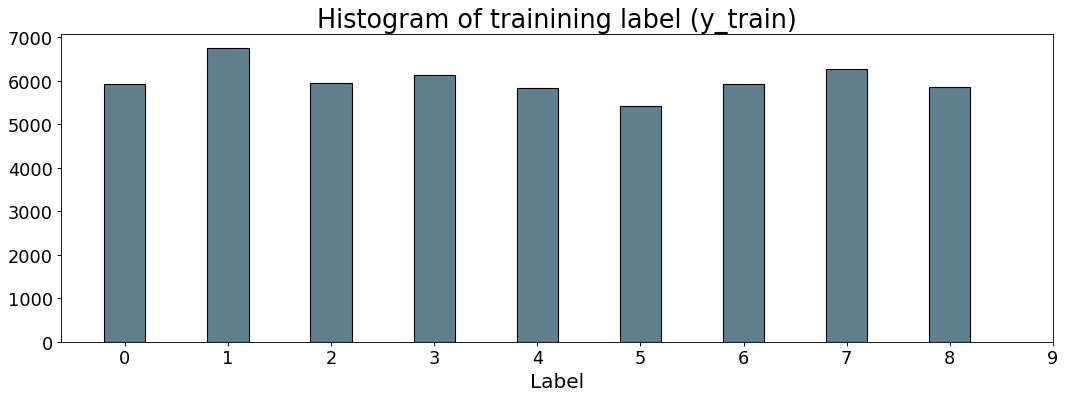

In [8]:
fig, axs = plt.subplots(figsize=(16, 5), dpi=80)
x_ticks = np.arange(min(y_train), max(y_train)+1, 1)
bins = x_ticks - 0.5
plt.hist(y_train, edgecolor='k', rwidth=0.4, bins=bins, color='#608090')
plt.title('Histogram of trainining label (y_train)', size=23)
plt.xlabel('Label', size=18)
plt.xticks(x_ticks, size=16)
plt.yticks(size=16)
plt.show()

### Looking at some samples of MNIST training set

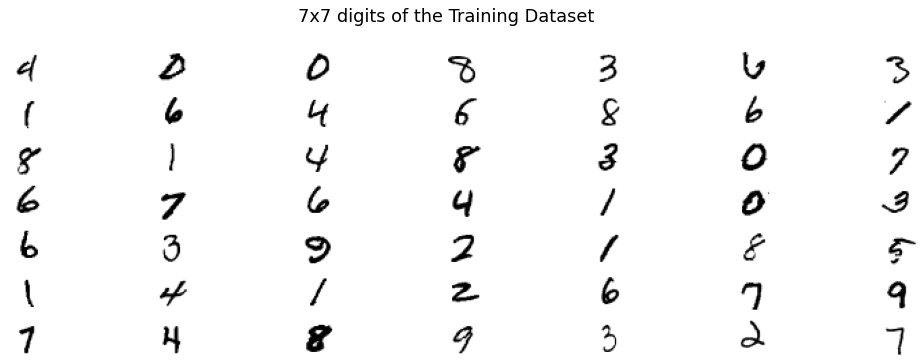

In [9]:
n_mat = 7
fig, axs = plt.subplots(nrows=n_mat, ncols=n_mat, figsize=(16, 5), dpi=80)
for idx, ax in enumerate(axs.ravel()):    
    ax.imshow(X_train[np.random.randint(0,len(X_train))].reshape(28, 28), cmap='binary')
    ax.axis('off')
    fig.suptitle(f'{n_mat}x{n_mat} digits of the Training Dataset', fontsize=16)

<a id='training'></a>

## [^](#summary) Training Autoencoders

### Normalize dataset

In [10]:
X_train = X_train - X_train.mean(axis=0, keepdims=0)

X_train = X_train/255
X_test = X_test/255

X_train, X_valid = X_train[:-10000], X_train[-10000:] # 5000
y_train, y_valid = y_train[:-10000], y_train[-10000:]

In [11]:
X_train.shape

(50000, 28, 28)

### Standard stacked autoencoder

In [12]:
init_time = time.time()

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])

decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

model_autoenconder_std = keras.models.Sequential([encoder, decoder])

model_autoenconder_std.compile(loss='binary_crossentropy',
                           optimizer=keras.optimizers.SGD(learning_rate=1.5),
                           metrics='mean_squared_logarithmic_error')                           
    
history_std = model_autoenconder_std.fit(X_train, X_train,
                                         epochs=N_EPOCHS, validation_data=(X_valid, X_valid))

# print(f'Elapsed time: {time.time() - init_time} s')

Epoch 1/77
1563/1563 [==============================] - 15s 2ms/step - loss: -0.5033 - mean_squared_logarithmic_error: 0.0206 - val_loss: -0.7130 - val_mean_squared_logarithmic_error: 0.0151
Epoch 2/77
1563/1563 [==============================] - 2s 1ms/step - loss: -0.7619 - mean_squared_logarithmic_error: 0.0137 - val_loss: -0.8131 - val_mean_squared_logarithmic_error: 0.0123
Epoch 3/77
1563/1563 [==============================] - 2s 1ms/step - loss: -0.8263 - mean_squared_logarithmic_error: 0.0117 - val_loss: -0.8515 - val_mean_squared_logarithmic_error: 0.0110
Epoch 4/77
1563/1563 [==============================] - 2s 2ms/step - loss: -0.8572 - mean_squared_logarithmic_error: 0.0106 - val_loss: -0.8743 - val_mean_squared_logarithmic_error: 0.0098
Epoch 5/77
1563/1563 [==============================] - 2s 2ms/step - loss: -0.8751 - mean_squared_logarithmic_error: 0.0099 - val_loss: -0.8888 - val_mean_squared_logarithmic_error: 0.0093
Epoch 6/77
1563/1563 [===========================

Epoch 44/77
1563/1563 [==============================] - 2s 1ms/step - loss: -0.9562 - mean_squared_logarithmic_error: 0.0059 - val_loss: -0.9574 - val_mean_squared_logarithmic_error: 0.0063
Epoch 45/77
1563/1563 [==============================] - 2s 1ms/step - loss: -0.9565 - mean_squared_logarithmic_error: 0.0059 - val_loss: -0.9602 - val_mean_squared_logarithmic_error: 0.0061
Epoch 46/77
1563/1563 [==============================] - 2s 1ms/step - loss: -0.9567 - mean_squared_logarithmic_error: 0.0059 - val_loss: -0.9603 - val_mean_squared_logarithmic_error: 0.0062
Epoch 47/77
1563/1563 [==============================] - 2s 1ms/step - loss: -0.9570 - mean_squared_logarithmic_error: 0.0059 - val_loss: -0.9605 - val_mean_squared_logarithmic_error: 0.0060
Epoch 48/77
1563/1563 [==============================] - 2s 2ms/step - loss: -0.9574 - mean_squared_logarithmic_error: 0.0059 - val_loss: -0.9620 - val_mean_squared_logarithmic_error: 0.0059
Epoch 49/77
1563/1563 [======================

### Variational autoencoder

In [13]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [14]:
init_time = time.time()

keras.backend.clear_session()
K = keras.backend

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(64, activation='selu')(z)
z = keras.layers.Dense(32, activation='selu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(inputs=[inputs], 
                                         outputs=[codings_mean, 
                                                  codings_log_var, 
                                                  codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(32, activation='selu')(decoder_inputs)
x = keras.layers.Dense(64, activation='selu')(x)
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
model_variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
model_variational_ae.add_loss(K.mean(latent_loss)/784)
model_variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop',
                       metrics='mean_squared_logarithmic_error')
history_variational = model_variational_ae.fit(X_train, X_train, 
                                               epochs=N_EPOCHS, batch_size=128,
                                               validation_data=(X_valid, X_valid))

# print(f'Elapsed time: {time.time() - init_time} s')

Epoch 1/77
391/391 [==============================] - 3s 3ms/step - loss: -0.1035 - mean_squared_logarithmic_error: 0.0314 - val_loss: -0.2709 - val_mean_squared_logarithmic_error: 0.0223
Epoch 2/77
391/391 [==============================] - 1s 2ms/step - loss: -0.3389 - mean_squared_logarithmic_error: 0.0214 - val_loss: -0.4432 - val_mean_squared_logarithmic_error: 0.0201
Epoch 3/77
391/391 [==============================] - 1s 2ms/step - loss: -0.4861 - mean_squared_logarithmic_error: 0.0193 - val_loss: -0.5312 - val_mean_squared_logarithmic_error: 0.0183
Epoch 4/77
391/391 [==============================] - 1s 2ms/step - loss: -0.5468 - mean_squared_logarithmic_error: 0.0179 - val_loss: -0.5830 - val_mean_squared_logarithmic_error: 0.0168
Epoch 5/77
391/391 [==============================] - 1s 2ms/step - loss: -0.5962 - mean_squared_logarithmic_error: 0.0167 - val_loss: -0.6266 - val_mean_squared_logarithmic_error: 0.0157
Epoch 6/77
391/391 [==============================] - 1s 2ms

391/391 [==============================] - 1s 3ms/step - loss: -0.7806 - mean_squared_logarithmic_error: 0.0116 - val_loss: -0.7880 - val_mean_squared_logarithmic_error: 0.0114
Epoch 45/77
391/391 [==============================] - 1s 2ms/step - loss: -0.7814 - mean_squared_logarithmic_error: 0.0116 - val_loss: -0.7885 - val_mean_squared_logarithmic_error: 0.0115
Epoch 46/77
391/391 [==============================] - 1s 2ms/step - loss: -0.7820 - mean_squared_logarithmic_error: 0.0115 - val_loss: -0.7889 - val_mean_squared_logarithmic_error: 0.0117
Epoch 47/77
391/391 [==============================] - 1s 2ms/step - loss: -0.7827 - mean_squared_logarithmic_error: 0.0115 - val_loss: -0.7898 - val_mean_squared_logarithmic_error: 0.0115
Epoch 48/77
391/391 [==============================] - 1s 2ms/step - loss: -0.7833 - mean_squared_logarithmic_error: 0.0115 - val_loss: -0.7898 - val_mean_squared_logarithmic_error: 0.0115
Epoch 49/77
391/391 [==============================] - 1s 2ms/step 

### Recurrent autoencoder

In [15]:
init_time = time.time()

recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(128)
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[128]),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

model_recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

model_recurrent_ae.compile(loss='binary_crossentropy', 
                           optimizer=keras.optimizers.SGD(0.3),                           
                           metrics='mean_squared_logarithmic_error')



history_recurrent_ae = model_recurrent_ae.fit(X_train, X_train, 
                                              epochs=N_EPOCHS,
                                              validation_data=(X_valid, X_valid))
                           
# print(f'Elapsed time: {time.time() - init_time} s')

Epoch 1/77
1563/1563 [==============================] - 21s 11ms/step - loss: -0.0891 - mean_squared_logarithmic_error: 0.0269 - val_loss: -0.2008 - val_mean_squared_logarithmic_error: 0.0241
Epoch 2/77
1563/1563 [==============================] - 17s 11ms/step - loss: -0.2574 - mean_squared_logarithmic_error: 0.0224 - val_loss: -0.2831 - val_mean_squared_logarithmic_error: 0.0216
Epoch 3/77
1563/1563 [==============================] - 17s 11ms/step - loss: -0.3823 - mean_squared_logarithmic_error: 0.0205 - val_loss: -0.4657 - val_mean_squared_logarithmic_error: 0.0193
Epoch 4/77
1563/1563 [==============================] - 18s 11ms/step - loss: -0.5464 - mean_squared_logarithmic_error: 0.0177 - val_loss: -0.6084 - val_mean_squared_logarithmic_error: 0.0158
Epoch 5/77
1563/1563 [==============================] - 17s 11ms/step - loss: -0.6725 - mean_squared_logarithmic_error: 0.0147 - val_loss: -0.7373 - val_mean_squared_logarithmic_error: 0.0122
Epoch 6/77
1563/1563 [==================

1563/1563 [==============================] - 18s 11ms/step - loss: -1.0108 - mean_squared_logarithmic_error: 0.0028 - val_loss: -1.0174 - val_mean_squared_logarithmic_error: 0.0027
Epoch 44/77
1563/1563 [==============================] - 17s 11ms/step - loss: -1.0125 - mean_squared_logarithmic_error: 0.0027 - val_loss: -1.0144 - val_mean_squared_logarithmic_error: 0.0031
Epoch 45/77
1563/1563 [==============================] - 17s 11ms/step - loss: -1.0129 - mean_squared_logarithmic_error: 0.0027 - val_loss: -0.9635 - val_mean_squared_logarithmic_error: 0.0051
Epoch 46/77
1563/1563 [==============================] - 18s 11ms/step - loss: -1.0139 - mean_squared_logarithmic_error: 0.0027 - val_loss: -1.0181 - val_mean_squared_logarithmic_error: 0.0028
Epoch 47/77
1563/1563 [==============================] - 18s 11ms/step - loss: -1.0147 - mean_squared_logarithmic_error: 0.0026 - val_loss: -0.9968 - val_mean_squared_logarithmic_error: 0.0037
Epoch 48/77
1563/1563 [========================

<a id='results'></a>

## [^](#summary) Results

### Learning curves

In [16]:
# history_recurrent_ae.history

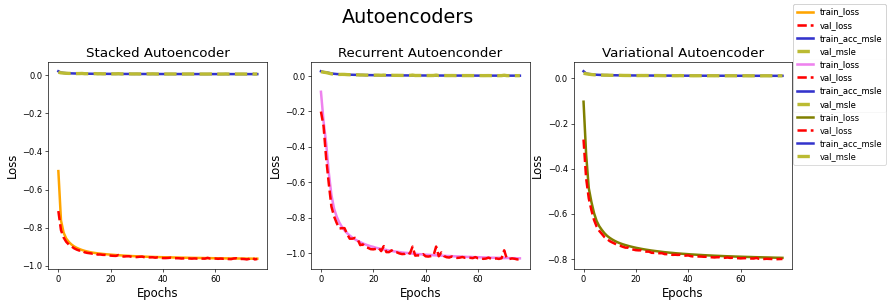

In [17]:
list_models = [(0, 'Stacked Autoencoder', model_autoenconder_std, history_std), 
               (1, 'Recurrent Autoenconder', model_recurrent_ae, history_recurrent_ae), 
               (2, 'Variational Autoencoder', model_variational_ae, history_variational)]
color_models = ['orange', 'violet', 'olive']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), dpi=60)
for idx, ax in enumerate(axs.ravel()):        
    ax.plot(list_models[idx][-1].history['loss'], label='train_loss',
            linewidth=3, c=color_models[idx])
    ax.plot(list_models[idx][-1].history['val_loss'], '--', label='val_loss',
           linewidth=3, c='red')
    ax.plot(list_models[idx][-1].history['mean_squared_logarithmic_error'], 
            label='train_acc_msle', linewidth=3, c='#3333cc')
    ax.plot(list_models[idx][-1].history['val_mean_squared_logarithmic_error'], '--',
            label='val_msle', linewidth=4, c='#bbbb33')
    ax.set_xlabel('Epochs', size=14)
    ax.set_ylabel('Loss', size=14)
    ax.set_title(f'{list_models[idx][1]}', size=16)
    fig.legend()
    fig.suptitle(f'Autoencoders', fontsize=23)
    fig.subplots_adjust(top=0.80)

### Load the model

In [18]:
# model_recurrent_ae = keras.models.load_model('model_recurrent_ae.keras')

### Save the model

In [19]:
model_recurrent_ae.save(f'model_recurrent_ae_{N_EPOCHS}_epochs.keras') 

<a id='reconstructions'></a>

## [^](#summary) Reconstructions

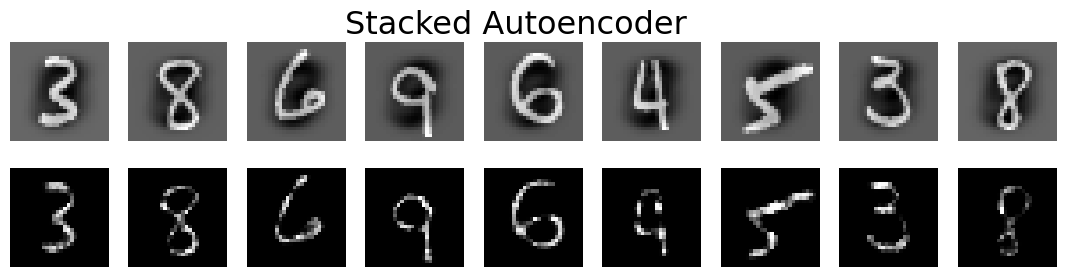

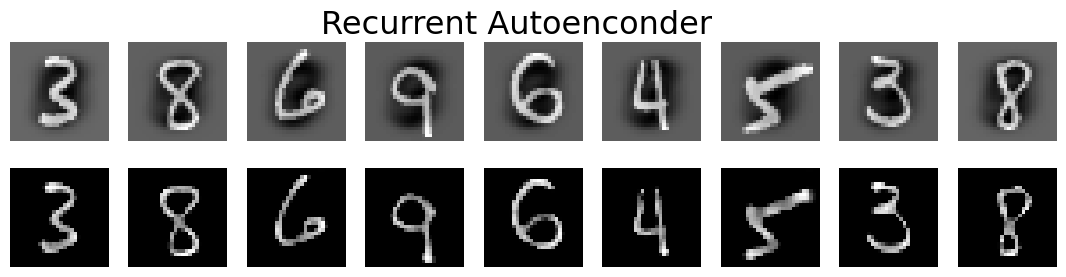

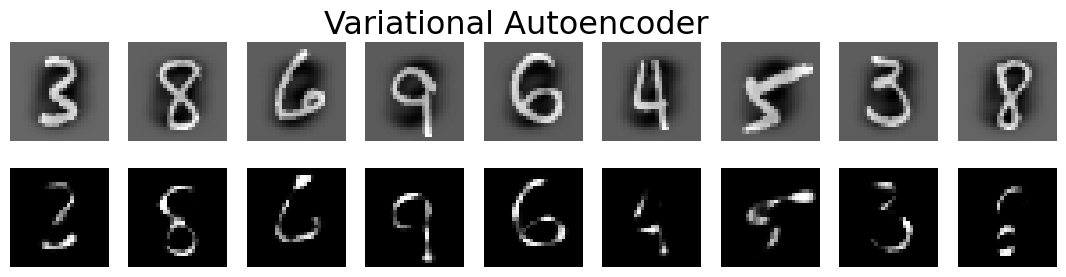

In [20]:
n_images_ = 9
images_ = X_valid

for item_model in range(len(list_models)):
    model = list_models[item_model][2]
    reconstructions = model.predict(images_[:n_images_], verbose='false')
    fig = plt.figure(figsize=(n_images_ * 1.5, 3))
    for img_idx in range(n_images_):
        plt.subplot(2, n_images_, 1 + img_idx)
        plt.imshow(images_[img_idx], cmap='gray')
        plt.axis('off')
        plt.subplot(2, n_images_, 1 + n_images_ + img_idx)
        plt.imshow(reconstructions[img_idx], cmap='gray')
        plt.suptitle(f'{list_models[item_model][1]}', fontsize=23)
        plt.axis('off')

Now, we will select one of these models based on the learning curves and reconstruction digits.

### Choosing the autoencoder model

In [21]:
# model_autoencoder, X_valid, X_test = model_recurrent_ae, X_valid.reshape(-1, 28*28), X_test.reshape(-1, 28*28)

model_autoencoder = model_recurrent_ae

# model_autoencoder = model_variational_ae

<a id='dim_reduction'></a>

## [^](#summary) Dimensionality reduction

We will transform the data from a high-dimensional space into a low-dimensional space.
It is expected that projection representations retain the maximum amount of meaningful information from the original data.

### Validation set

In [22]:
X_valid.shape

(10000, 28, 28)

In [23]:
y_valid.shape

(10000,)

### Training t-SNE

In [24]:
from sklearn.manifold import TSNE
import matplotlib as mpl

model_tsne = TSNE()

In [25]:
def plot_graph_tsne_2d(X_graph, y_graph):
    plt.figure(figsize=(13, 10), dpi=90)
    colormap = plt.cm.tab10
    
    X_graph_compressed = model_autoencoder.predict(X_graph)
    
    X_graph_2D = model_tsne.fit_transform(X_graph_compressed.reshape(-1, 28*28))
    X_graph_2D = (X_graph_2D - X_graph_2D.min())/(X_graph_2D.max() - X_graph_2D.min())
    
    plt.scatter(X_graph_2D[:, 0], X_graph_2D[:, 1], c=y_graph, s=10, cmap=colormap)    
    
    img_pos = np.array([[1, 1]])
    for idx, pos in enumerate(X_graph_2D):
        d = np.sum((pos - img_pos)**2, axis=1)
        if np.min(d) > 0.02:
            img_pos = np.r_[img_pos, [pos]]
            imgbox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(X_graph[idx], cmap='binary'),
                pos, bboxprops={'edgecolor': colormap(y_graph[idx]), 'lw': 2})
            plt.gca().add_artist(imgbox)

    plt.axis('off')
    plt.show()

313/313 [==============================] - 1s 4ms/step


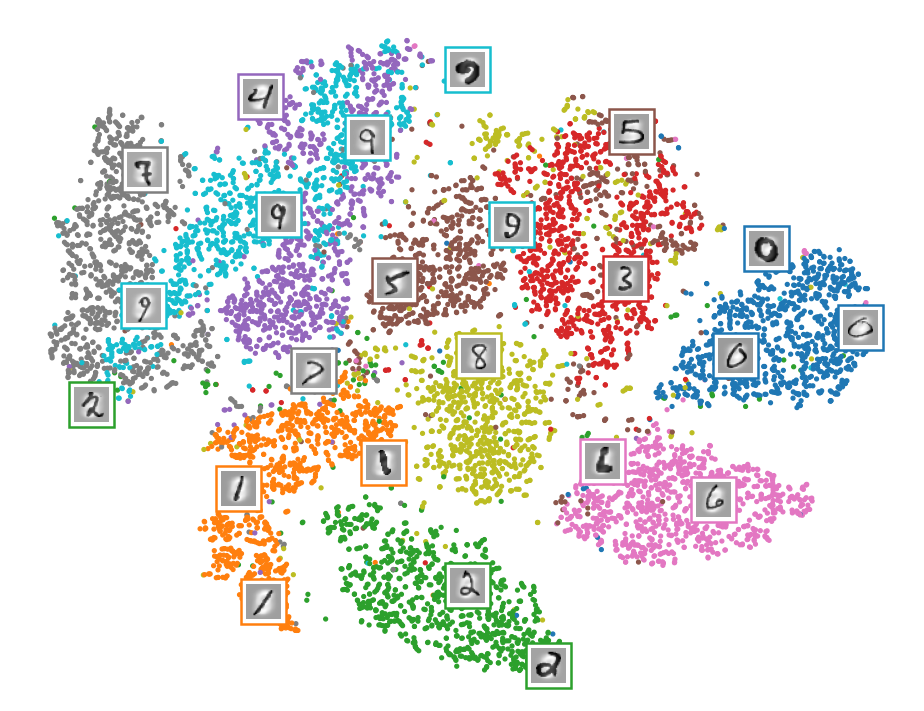

In [26]:
plot_graph_tsne_2d(X_valid, y_valid)

### Test set

In [27]:
X_test.shape

(10000, 28, 28)

In [28]:
y_test.shape

(10000,)

313/313 [==============================] - 1s 4ms/step


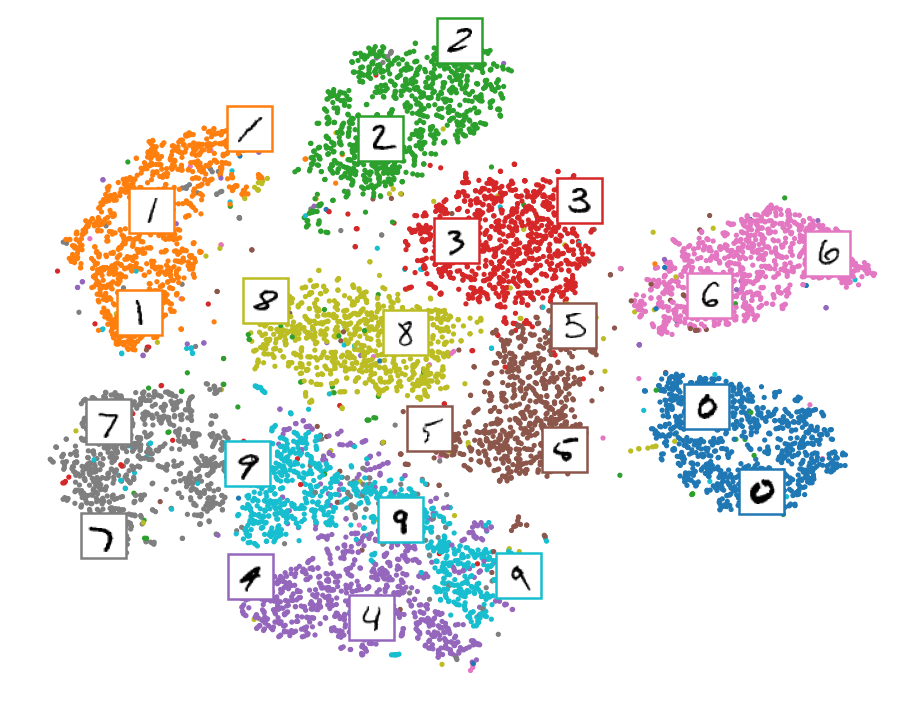

In [29]:
plot_graph_tsne_2d(X_test, y_test)

In [30]:
# print(f'Total elapsed time: {time.time() - init_time_global} s')

___
<a id='next_steps'></a>

## [^](#summary) Next steps

- Change the dataset to: [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html), or [other](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research).

- Reproduce the results of ["Kramer, M. A. (1991). <i>Nonlinear principal component analysis using autoassociative neural networks</i>"](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=87c280d0dc204ca5db0d325991a21c211aeec866).

- Explore [others applications of the autoencoder]((https://scholar.google.com/scholar?hl=pt-BR&as_sdt=0%2C5&q=autoencoders+applications&btnG=)).

___
<a id='refs'></a>
## [^](#summary) References 

- https://en.wikipedia.org/wiki/Autoencoder

- [Géron, A. (2019). <i>Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow</i>.](https://github.com/ageron/handson-ml2)

- https://en.wikipedia.org/wiki/Feature_learning

- https://en.wikipedia.org/wiki/Variational_autoencoder

- https://en.wikipedia.org/wiki/Dimensionality_reduction